# 01 Image Classification with fastai

## 1. The fastai Philosophy

In [6]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:90% !important; }</style>"))

- [fastai](https://www.fast.ai/) is a software package and course created by Jeremy Howard, Rachel Thomas, and Sylvain Gugger. 
- A good way to think about fastai is as a high level PyTorch wrapper library. If you're familiar with keras, **tensorflow is to keras and pytorch is (roughly) to fastai.**
- Unlike keras, fastai is **very opinionated** library. 
- Instead of creating a generic tools for deep learning experts to use, the fastai founders are creating courses and a library that make it **dramatically easier and faster** to get cutting-edge results quickly with deep learning. 
- One tool they use to accomplish this is by **encoding best practices from research directly into the library**. 
- This approach has led to some pretty dramatic results, including [training a model on imagenet in 18 minutes](https://www.fast.ai/2018/08/10/fastai-diu-imagenet/) and some breakthrough results in [pretraining models for natural language processing](https://arxiv.org/pdf/1801.06146.pdf). 
- Now, there are some trade-offs. In my experience, fastai can be buggy, difficult to debug, and challenging to generalize in some cases. 
- My thinking on these trade-offs, in 2020, is this: 


1. For quickly exploring + testing top-performing models and new ideas on your own datasets, **it's hard to beat fastai**. In my experience, you'll be able to test lots of ideas quickly, and move fast. 
2. Having a reasonable good understanding of the underlying PyTorch code can make you much more effective with fastai, allowing you to "pick and choose" the parts of the fastai library you want to use, and what you want to implement yourself in PyTorch. 
3. I still really like Keras and Tensorflow, but I rarely use these libraries as **starting points** on new projects. 

---

## 2. Let's Get Some Data

In [3]:
from util.get_and_unpack import get_and_unpack

In [4]:
get_and_unpack(url='http://www.welchlabs.io/unccv/deep_learning/bbc_train.zip')

 Downloading...this might take a little while...
Downloading: 100% [90591239 / 90591239] bytes
 Unzipping...
Done!


**Optional in Workshop - let's code this part together from scratch in an empty notebook.**

In [7]:
%pylab inline
from fastai.vision import *
from pathlib import Path
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


ModuleNotFoundError: No module named 'fastai'

In [ ]:
path=Path('data/bbc_train')

In [4]:
path.ls()

[PosixPath('../data/bbc_train/images'),
 PosixPath('../data/bbc_train/classification_labels.csv'),
 PosixPath('../data/bbc_train/bboxes.json'),
 PosixPath('../data/bbc_train/.DS_Store'),
 PosixPath('../data/bbc_train/masks')]

- The BBC-1k dataset inlcudes labels for classification, bounding box detection, and semantic segmentation. 
- Let's load the classification labels:

In [5]:
labels=pd.read_csv(path/'classification_labels.csv')

In [6]:
labels.head()

filename  label  label_index
0  P2050936.jpg   ball            2
1  P2050922.jpg   ball            2
2  P2060163.jpg  brick            1
3  P2060003.jpg   ball            2
4  P2060017.jpg   ball            2

- fastai provides lots of methods for creating data iterators, called `DataBunches` in the fastai nomenclature
- `DataBunches` allow us to quickly create pipelines for loading data into randomized minibatches

## 3. Setup fastai ImageDataBunch

In [7]:
data=ImageDataBunch.from_df(path=path/'images', df=labels, valid_pct=0.2, fn_col='filename', label_col='label', 
                            ds_tfms=get_transforms(), size=256, bs=64).normalize(imagenet_stats)

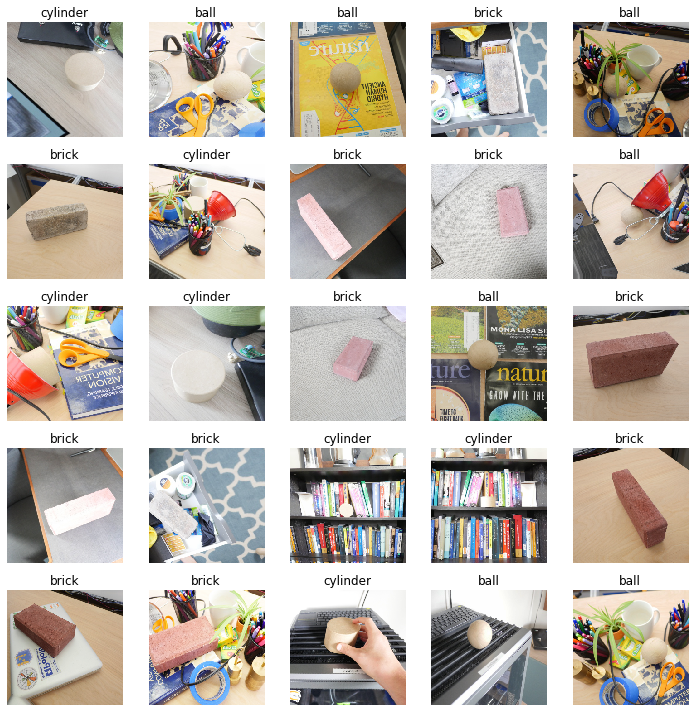

In [8]:
data.show_batch(figsize=(10,10))

- Creating a model is as simple as picking an architecture, passing in our `ImageDataBunch`, and choosing a performance metric!

## 4. Create Learner, Find Learning Rate

In [9]:
learn=cnn_learner(data, models.resnet34, metrics=accuracy)

- By defualt, fastai downloads the weights for a pretrained model. 
- Usually when solving new problems, it's best to start with a pretrained model, and just train the last few layers on the new task. 
- We can do this by freezing the "model backbone": 

In [10]:
learn.freeze()

- Choosing a learning rate can be difficult. 
- fastai provides a great tool for selecting an effective learning rate, `learn.lr_find()`.
- `lr_find` takes steps using various learning rates, and measure the change in our loss function. 
- By plotting the loss as a function of learning rate, we can select an ideal learning rate. 
- Ideally, we want to pick a learning that maximizes the slope of our loss vs learning rate curve. 

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

- Fastai has a couple of other terrific built in features, **cylical learning rates**, and **differential learning rates**. 
- We're using each of these here, and will cover them in more detail later. 

## 5. Train Model

In [ ]:
lr=5e-3
learn.fit_one_cycle(4, slice(lr/10, lr))

- We can further improve performance by training the whole model, not just our last few layers. 

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
lr=5e-5
learn.fit_one_cycle(8, slice(lr/10, lr))

## 6. Visualize Results

- fastai also has some really nice visualization & interpretation methods:

In [ ]:
interp=ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_confusion_matrix(figsize=(6,6))

In [ ]:
interp.plot_top_losses(k=6, figsize=(12, 8))

## 3. Object Detection with fastai

- Let's see what else we can do with fastai!
- Thanks to some hard work from the terrifice UNCC TAs, we also have bounding box annotations for each image in our dataset. 
- Let's see if we can train a deep learning model to detect bounding boxes around our bricks, balls, cylinders!
- **What modifications to our neural network do we need to make to our network to allow it make this kinda of prediction?**
- What really remarkable (as you'll see) is how little we really need to change to perform this task well. 

In [1]:
%pylab inline
from fastai.vision import *
from pathlib import Path
import pandas as pd
import json

Populating the interactive namespace from numpy and matplotlib


### 3.1 Data 

In [2]:
path=Path('../data/bbc_train')

In [3]:
path.ls()

[PosixPath('../data/bbc_train/images'),
 PosixPath('../data/bbc_train/classification_labels.csv'),
 PosixPath('../data/bbc_train/bboxes.json'),
 PosixPath('../data/bbc_train/.DS_Store'),
 PosixPath('../data/bbc_train/models'),
 PosixPath('../data/bbc_train/masks')]

In [4]:
labels=json.load(open(path/'bboxes.json', 'r'))

In [5]:
labels.keys()

dict_keys(['images', 'annotations', 'type', 'categories'])

In [6]:
labels['annotations'][12]['bbox']

[282.39102564102564, 174.0, 70.19230769230762, 67.62820512820511]

- Instead of writing our own json importer, we'll us a fastai method for this:

In [7]:
images, lbl_bbox = get_annotations(path/'bboxes.json')

In [8]:
len(images), len(lbl_bbox)

(1185, 1185)

In [9]:
images[:5]

['P2050936.jpg',
 'P2050922.jpg',
 'P2060163.jpg',
 'P2060003.jpg',
 'P2060017.jpg']

In [10]:
lbl_bbox[0]

[[[145.47435897435898,
   254.82692307692304,
   237.14102564102564,
   347.4551282051282]],
 ['ball']]

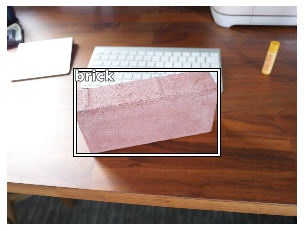

In [11]:
i=2
img = open_image(path/'images'/images[i])
bbox = ImageBBox.create(*img.size, lbl_bbox[i][0], [0], classes=lbl_bbox[i][1])
img.show(figsize=(6,4), y=bbox)

- Let's setup our fastai data loading pipeline:

In [12]:
img2bbox = dict(zip(images, lbl_bbox))
get_y_func = lambda o:img2bbox[o.name]

In [13]:
def get_data(bs, size):
    src = ObjectItemList.from_folder(path/'images')
    src = src.split_by_rand_pct(0.2)
    src = src.label_from_func(get_y_func)
    src = src.transform(get_transforms(max_rotate=0), size=size, tfm_y=True)
    return src.databunch(path=path, bs=bs, collate_fn=bb_pad_collate)

In [14]:
data = get_data(bs=64,size=256)

In [15]:
data

ImageDataBunch;

Train: LabelList (754 items)
x: ObjectItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ObjectCategoryList
ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256)
Path: ../data/bbc_train/images;

Valid: LabelList (188 items)
x: ObjectItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ObjectCategoryList
ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256)
Path: ../data/bbc_train/images;

Test: None

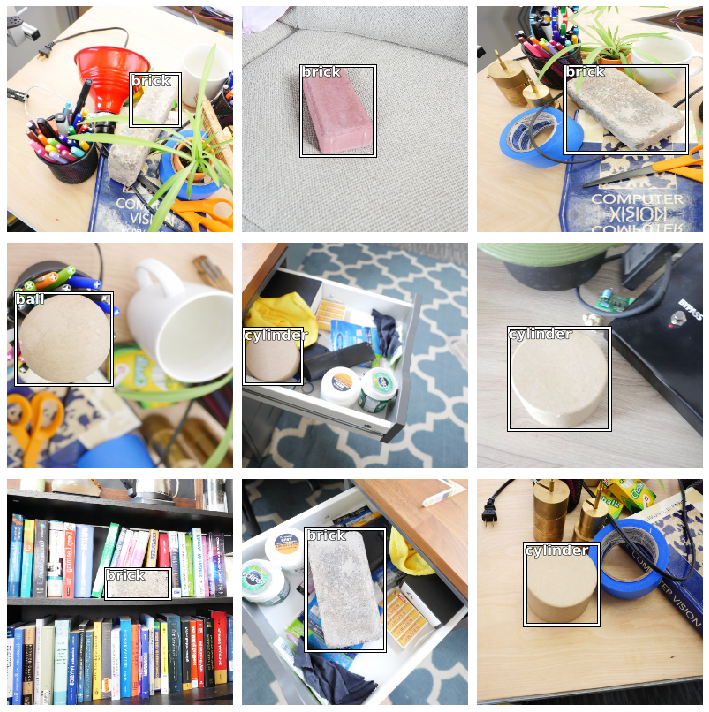

In [16]:
data.show_batch(rows=3, figsize=(10,10))

### 3.2 Model

- Now that our dataloading pipeline is setup, let's think about what changes we need to make to our network. 
- A nice feature of fastai is the ability to easilty attach a "custom head" to a pretrained "backbone". 
- Let's start thinking about the type of output we for our object detection network. 
- Is this a Regression or Classification Problem?
- What is the Dimenion of the output we need from our neural network?

---

- We'll create our own custom head and loss function here
- Don't worry about the exact implementation details here too much just yet - mostly pay attention to the dimensions of the inputs and outputs!
- `AdaptiveConcatPool2d` is a really nice layer that allows us to handle input images of different sizes. 

In [18]:
custom_head = nn.Sequential(
    AdaptiveConcatPool2d((4,4)),
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(16384,256), #2*512*4*4
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256,4))

In [19]:
class MyLoss(nn.Module):
    def forward(self, output, bbox_tgts, class_tgts):
        return nn.L1Loss()(output.unsqueeze_(dim=1), bbox_tgts)

In [20]:
learn=cnn_learner(data, models.resnet34, custom_head=custom_head, loss_func=MyLoss())

In [21]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 128, 128]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 128, 128]       128        True      
______________________________________________________________________
ReLU                 [64, 128, 128]       0          False     
______________________________________________________________________
MaxPool2d            [64, 64, 64]         0          False     
______________________________________________________________________
Conv2d               [64, 64, 64]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
___________________________________________________

In [22]:
learn.freeze()

In [22]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


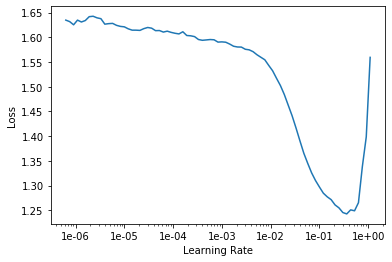

In [23]:
learn.recorder.plot()

In [23]:
lr=1e-2
learn.fit_one_cycle(4, slice(lr/10, lr))

In [24]:
learn.unfreeze()

In [25]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


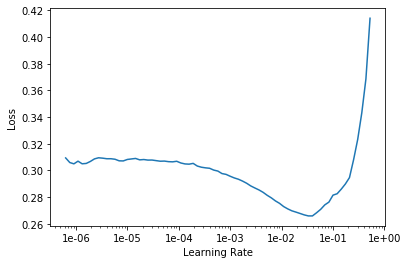

In [26]:
learn.recorder.plot()

In [27]:
lr=1e-3
learn.fit_one_cycle(8, slice(lr/10, lr))

In [28]:
lr=5e-4
learn.fit_one_cycle(8, slice(lr/10, lr))

In [30]:
learn.save('object-detector-1')

### 3.3 Visualize Results

In [35]:
def compute_corner_locations(y, im_shape=(256,256)):
    shape_vec=np.array(im_shape*2)
    bounds=((y+1)*shape_vec/2).ravel()
    corners=np.array([[bounds[1], bounds[0]], 
                      [bounds[3], bounds[0]],
                      [bounds[3], bounds[2]],
                      [bounds[1], bounds[2]],
                      [bounds[1], bounds[0]]])
    return corners

In [36]:
x,y = next(iter(learn.data.valid_dl))
with torch.no_grad():
    yhat = learn.model(x.to('cuda'))

In [37]:
x.shape, y[0].shape, yhat.shape

(torch.Size([64, 3, 256, 256]), torch.Size([64, 1, 4]), torch.Size([64, 4]))

In [38]:
#Reshape image block and convert to numpy for visualization: 
x_numpy=np.moveaxis(x.cpu().numpy(), (0, 2, 3, 1), (0, 1, 2, 3))

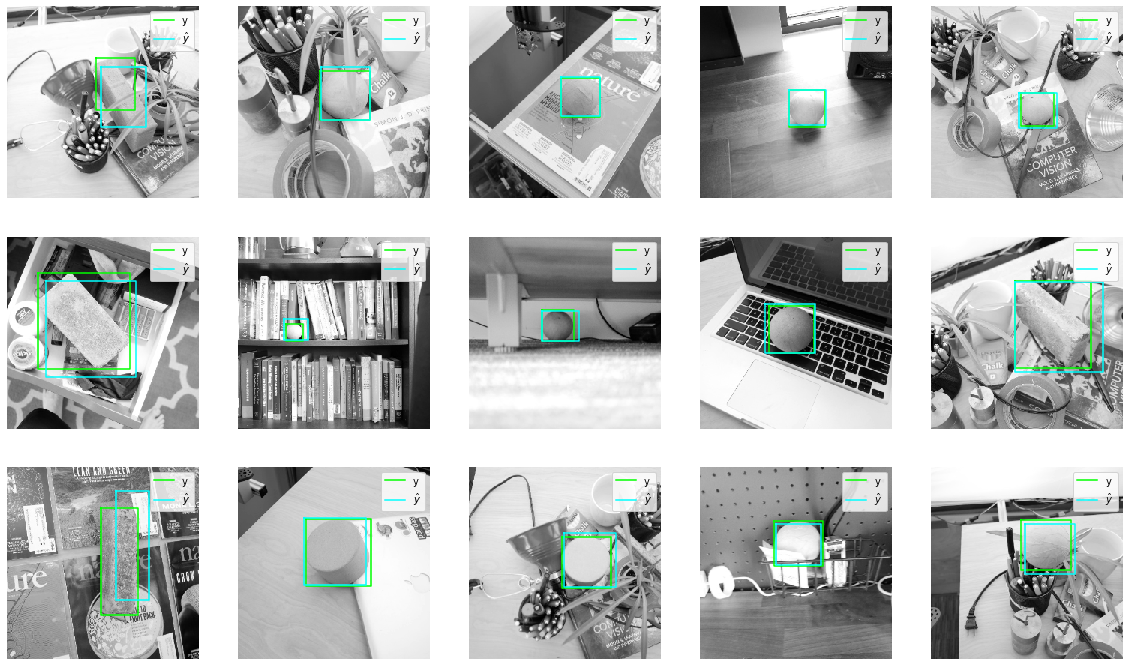

In [41]:
fig=figure(0, (20,12))
for i in range(15): 
    fig.add_subplot(3,5,i+1)
    imshow(x_numpy[i].mean(axis=2), cmap='gray')
    
    corners=compute_corner_locations(y[0][i].cpu().numpy())
    plot(corners[:, 0], corners[:,1], c=(0, 1, 0))
    
    corners=compute_corner_locations(yhat[i].cpu().numpy())
    plot(corners[:, 0], corners[:,1], c=(0, 1, 1))
    axis('off')
    legend(['y', '$\hat{y}$'])

- Not bad, right!?
- Now, there's a lot more to object detection - there's lots of ways to further improve on the performance we're achieving here. More importantly, we haven't solved object detection in the general case. **Why not?**
- This issue here is that we have no way for our algorithm to detect multple objects in the same image!
- There's alot that goes into handling multiple objects in the same image - the [SSD](https://arxiv.org/pdf/1512.02325.pdf), [Yolo](https://arxiv.org/pdf/1506.02640.pdf), and [RetinaNet](https://arxiv.org/pdf/1708.02002.pdf) papers are a great place to start learning about more sophisticated appraoches. 

## 4. Semantic Segmentation with fastai

- But wait, there's more! 
- Let's explore one more type of problem we can solve using a very similar architecture: **semantic segmentation**. 
- Our goal in semantic segmentation is to assign each pixel to a specific class. 
- Now is a good time to start thinking about what type of dimension we need for the output of our nueral network in order to solve this problem.

In [43]:
%pylab inline
from fastai.vision import *
from pathlib import Path
import pandas as pd
import json

Populating the interactive namespace from numpy and matplotlib


### 4.1 Data

In [44]:
path=Path('../data/bbc_train')

In [45]:
path.ls()

[PosixPath('../data/bbc_train/images'),
 PosixPath('../data/bbc_train/classification_labels.csv'),
 PosixPath('../data/bbc_train/bboxes.json'),
 PosixPath('../data/bbc_train/.DS_Store'),
 PosixPath('../data/bbc_train/models'),
 PosixPath('../data/bbc_train/masks')]

In [47]:
fnames = get_image_files(path/'images')
fnames[:3]

[PosixPath('../data/bbc_train/images/P2050886.jpg'),
 PosixPath('../data/bbc_train/images/P2050729.jpg'),
 PosixPath('../data/bbc_train/images/P2050513.jpg')]

In [48]:
lbl_names = get_image_files(path/'masks')
lbl_names[:3]

[PosixPath('../data/bbc_train/masks/P2050393.png'),
 PosixPath('../data/bbc_train/masks/P2050807.png'),
 PosixPath('../data/bbc_train/masks/P2050940.png')]

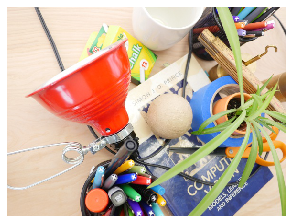

In [49]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [52]:
def get_y_fn(x): return path/'masks'/(x.stem + '.png')
classes = array(['background', 'brick', 'ball', 'cylinder'])

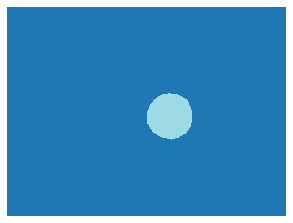

In [53]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [54]:
unique(mask.data)

array([0, 2])

In [57]:
src = (SegmentationItemList.from_folder(path/'images')
       .split_by_rand_pct(0.2)
       .label_from_func(get_y_fn, classes=classes))

In [58]:
data = (src.transform(get_transforms(), tfm_y=True, size=(256,256))
        .databunch(bs=16)
        .normalize(imagenet_stats))

In [59]:
data

ImageDataBunch;

Train: LabelList (754 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: ../data/bbc_train/images;

Valid: LabelList (188 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: ../data/bbc_train/images;

Test: None

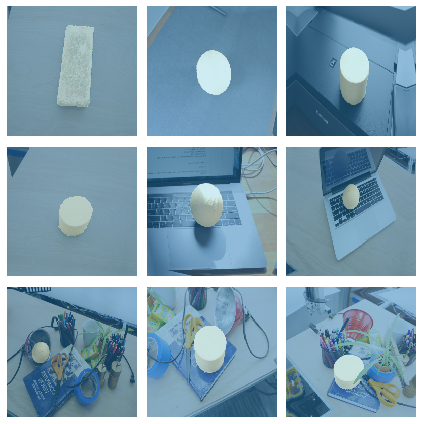

In [60]:
data.show_batch(3, figsize=(6,6))

### 4.2 Model

- Now, as you may have guessed we need to implement another custom head. 
- However, this time we need a slightly more complicated architecture for this portion of our network. 
- The challenge here is that we need to **upsample**, or make our tensors larger as they pass through the network. 
- We can achieve this using a special operation called a **transposed convoulation** - we'll dig more into the details of this operation later. 
- The thing to know for knwo is that transposed convulutional layers in our neural network allow us to learn an "upsampling" or mapping form smaller to larger tensors. 

In [61]:
def conv_trans(ni, nf, ks = 4, stride = 2, padding = 1):
    return nn.Sequential(
        nn.ConvTranspose2d(ni, nf, kernel_size=ks, bias=False, stride=stride, padding = padding), 
        nn.ReLU(inplace = True), 
        nn.BatchNorm2d(nf))

In [62]:
custom_head=nn.Sequential(conv_trans(512, 256), 
                          conv_trans(256, 128),
                          conv_trans(128, 64),
                          conv_trans(64, 32), 
                          nn.ConvTranspose2d(32, 4, kernel_size=4, bias=False, stride=2, padding = 1))

- We need to intorduce a slightly specialized performance measure here, the accuracy evaluate pixel by pixel (like we're solving a classification problem for each pixel!

In [64]:
def pixel_accuracy(yhat, y):
    y_=y.squeeze(dim=1)
    yhat_=yhat.argmax(dim=1)
    return (y_==yhat_).sum().float()/y.numel()

In [65]:
learn=cnn_learner(data, models.resnet18, custom_head=custom_head, metrics=pixel_accuracy)

In [66]:
learn.freeze()

In [67]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


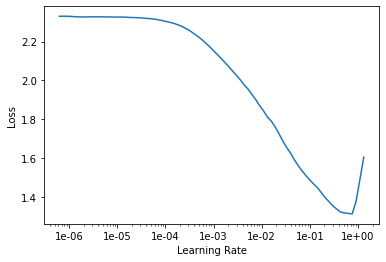

In [68]:
learn.recorder.plot()

In [69]:
lr=1e-2
learn.fit_one_cycle(4, slice(lr/10, lr))

In [70]:
learn.unfreeze()

In [71]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


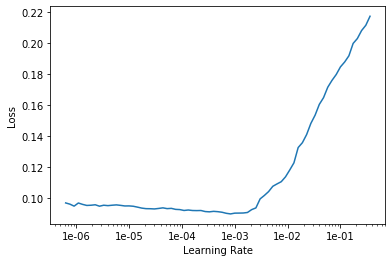

In [72]:
learn.recorder.plot()

In [73]:
lr=1e-4
learn.fit_one_cycle(8, slice(lr/10, lr))

In [74]:
learn.save('basic-segmentation')

### 4.3 Results

In [75]:
def blend_image_mask(im, mask, alpha=0.7):
    im_mask=np.zeros((im.shape[1], im.shape[2], 3), dtype='float32')
    for j in range(3): im_mask[:,:,j]=im.mean(axis=0)
    for j in range(1, 4):
        im_mask[mask==j] = alpha*im_mask[mask==j] + (1-alpha)*np.array([float(i==(j-1)) for i in range(3)])
    return im_mask

In [76]:
def make_legend():
    custom_lines = [Line2D([0], [0], color='r', lw=2, alpha=0.5),
                    Line2D([0], [0], color='g', lw=2, alpha=0.5),
                    Line2D([0], [0], color='b', lw=2, alpha=0.5)]

    legend(custom_lines, ['Brick', 'Ball', 'Cylinder'])

In [77]:
denorm=learn.data.denorm

In [78]:
with torch.no_grad():
    x,y = next(iter(learn.data.valid_dl))
    yhat = to_np(learn.model(x))
    x=denorm(x)

In [79]:
x.shape, y.shape, yhat.shape

(torch.Size([16, 3, 256, 256]),
 torch.Size([16, 1, 256, 256]),
 (16, 4, 256, 256))

In [80]:
yhat=yhat.argmax(1)

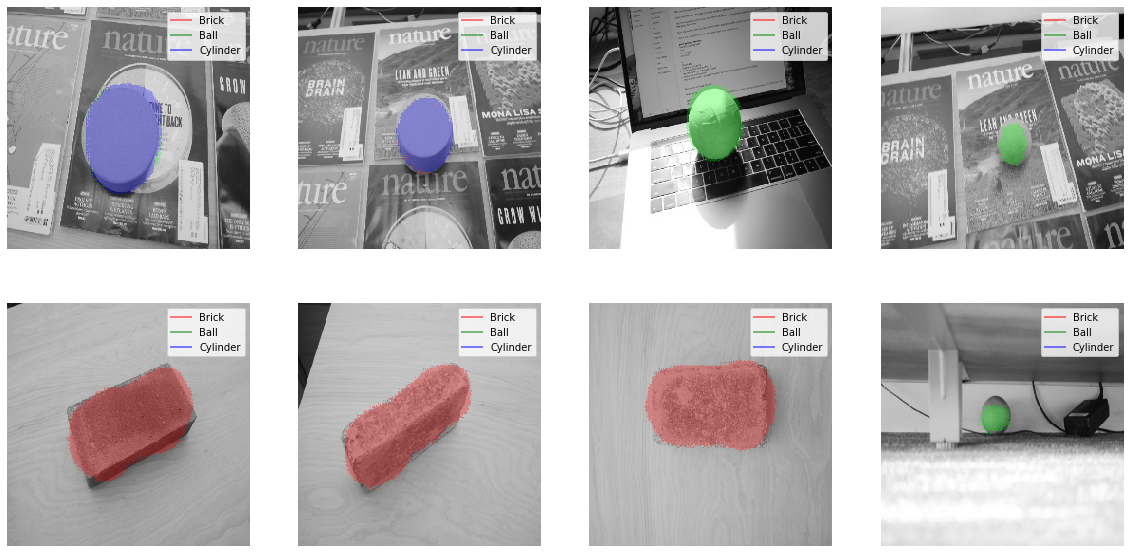

In [81]:
fig=figure(0, (20, 10))

for i in range(8):
    fig.add_subplot(2,4,i+1)
    im_mask=blend_image_mask(x[i], yhat[i])
    imshow(im_mask); axis('off'); make_legend()

## 5. Multitask Learning with fastai

- Before we wrap up our whirlwind tour of fastai, let's experiemnt with one more idea. 
- We saw how using the same pretrained resnet backbone, we can quickly specialize our network to perform varoius task. 
- Now, let's consider how we might setup our network to learn **multiple things at once** - why might we want to do this?
- Let's start by trying to group two problems we solved earlier - classification and bounding box detetection.

In [82]:
%pylab inline
from fastai.vision import *
from pathlib import Path
import pandas as pd
import json

Populating the interactive namespace from numpy and matplotlib


/home/ubuntu/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['__version__', 'array', 'copy', 'uniform', 'partition', 'random', 'pad', 'subplots']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### 5.1 Data

In [84]:
path=Path('../data/bbc_train')

In [85]:
path.ls()

[PosixPath('../data/bbc_train/images'),
 PosixPath('../data/bbc_train/classification_labels.csv'),
 PosixPath('../data/bbc_train/bboxes.json'),
 PosixPath('../data/bbc_train/.DS_Store'),
 PosixPath('../data/bbc_train/models'),
 PosixPath('../data/bbc_train/masks')]

In [88]:
images, lbl_bbox = get_annotations(path/'bboxes.json')

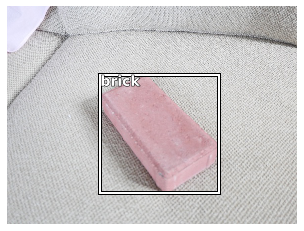

In [92]:
i=31
img = open_image(path/'images'/images[i])
bbox = ImageBBox.create(*img.size, lbl_bbox[i][0], [0], lbl_bbox[i][1])
img.show(figsize=(6,4), y=bbox)

In [93]:
img2bbox = dict(zip(images, lbl_bbox))
get_y_func = lambda o:img2bbox[o.name]

In [94]:
src = ObjectItemList.from_folder(path/'images')

In [98]:
def get_data(bs, size):
    src = ObjectItemList.from_folder(path/'images')
    src = src.split_by_rand_pct(0.2)
    src = src.label_from_func(get_y_func)
    src = src.transform(get_transforms(max_rotate=0), size=size, tfm_y=True)
    return src.databunch(path=path, bs=bs, collate_fn=bb_pad_collate)

In [99]:
data = get_data(bs=64,size=256)

In [100]:
data

ImageDataBunch;

Train: LabelList (754 items)
x: ObjectItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ObjectCategoryList
ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256)
Path: ../data/bbc_train/images;

Valid: LabelList (188 items)
x: ObjectItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ObjectCategoryList
ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256)
Path: ../data/bbc_train/images;

Test: None

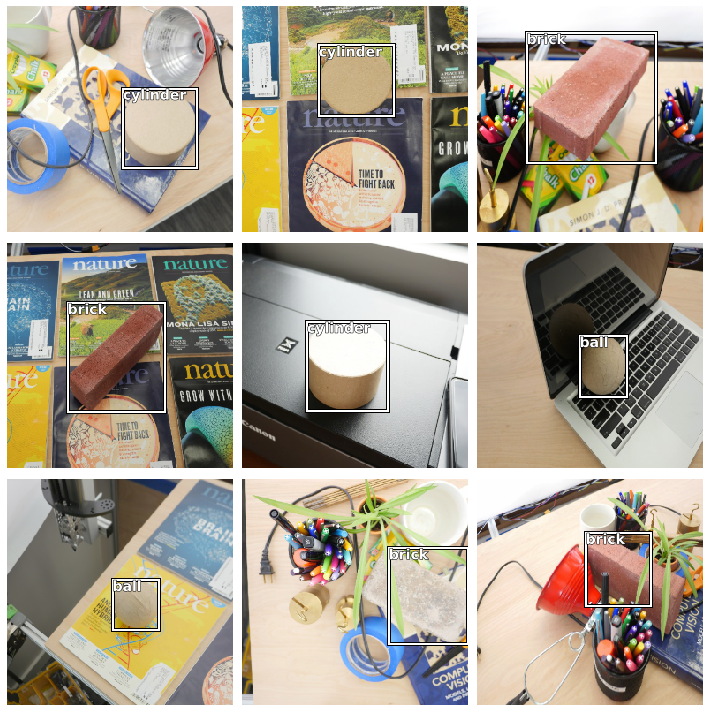

In [101]:
data.show_batch(rows=3, figsize=(10,10))

### 5.2 Model

- First, we need a loss function that takes into account both bounding box and classification performance. 
- Notize that we have a tunable balance between our two losses

In [102]:
class MyLoss(nn.Module):
    def forward(self, yhat, bbox_tgts, class_tgts):
        det_loss=nn.L1Loss()(yhat[:,:4].unsqueeze_(dim=1), bbox_tgts)
        cls_loss=nn.CrossEntropyLoss()(yhat[:,4:], class_tgts.view(-1))
        #print(det_loss, cls_loss)
        
        return det_loss + 1.0*cls_loss

In [103]:
def my_accuracy(yhat, bbox_tgts, class_tgts):
    return accuracy(yhat[:,4:], class_tgts.view(-1))

def my_l1(yhat, bbox_tgts, class_tgts):
    return nn.L1Loss()(yhat[:,:4].unsqueeze_(dim=1), bbox_tgts)

- What dimension does our output need to be to solve both classification and bounding box detection?

In [106]:
custom_head = nn.Sequential(
    AdaptiveConcatPool2d((4,4)),
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(16384,256), #2*512*4*4
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256,8))

In [107]:
learn=cnn_learner(data, models.resnet34, custom_head=custom_head, loss_func=MyLoss(), metrics=[my_accuracy, my_l1])

In [108]:
learn.freeze()

In [109]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


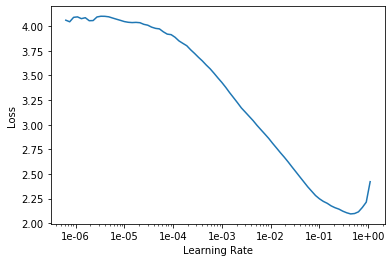

In [110]:
learn.recorder.plot()

In [111]:
lr=1e-2
learn.fit_one_cycle(4, slice(lr/10, lr))

In [112]:
learn.unfreeze()

In [113]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


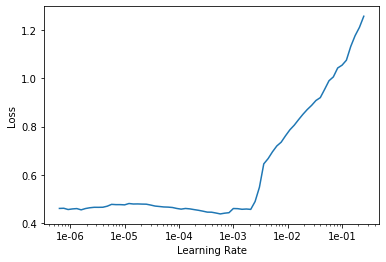

In [114]:
learn.recorder.plot()

In [115]:
lr=5e-4
learn.fit_one_cycle(8, slice(lr/10, lr))

In [116]:
lr=5e-4
learn.fit_one_cycle(8, slice(lr/10, lr))

In [117]:
learn.save('multitask-basic-model')

### 5.3 Results

In [121]:
with torch.no_grad():
    x,y = next(iter(learn.data.valid_dl))
    yhat = learn.model(x.to('cuda'))

In [122]:
x.shape, y[0].shape, yhat.shape

(torch.Size([64, 3, 256, 256]), torch.Size([64, 1, 4]), torch.Size([64, 8]))

In [123]:
#Reshape image block and convert to numpy for visualization: 
x_numpy=np.moveaxis(x.cpu().numpy(), (0, 2, 3, 1), (0, 1, 2, 3))

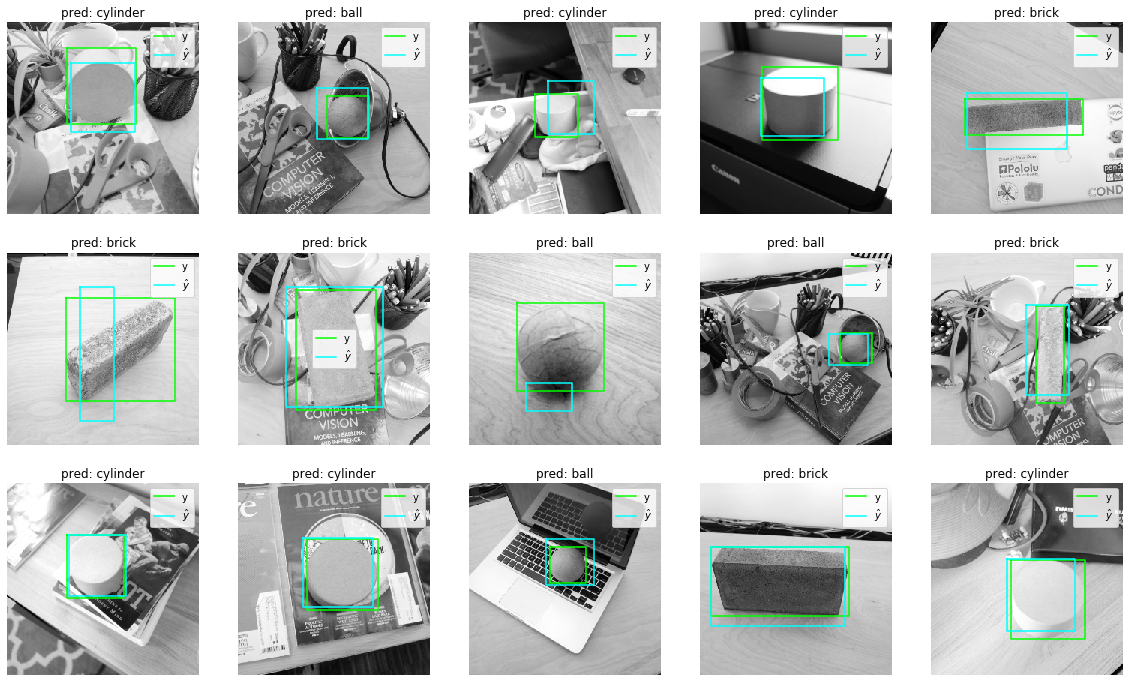

In [124]:
fig=figure(0, (20,12))
for i in range(15): 
    fig.add_subplot(3,5,i+1)
    imshow(x_numpy[i].mean(axis=2), cmap='gray')
    
    pred_class=learn.data.classes[yhat[i][4:].argmax()]
    title('pred: ' + pred_class)
    
    corners=compute_corner_locations(y[0][i].cpu().numpy())
    plot(corners[:, 0], corners[:,1], c=(0, 1, 0))
    
    corners=compute_corner_locations(yhat[i][:4].cpu().numpy())
    plot(corners[:, 0], corners[:,1], c=(0, 1, 1)); axis('off'); legend(['y', '$\hat{y}$'])

- What other types of interesting problems could you solve with multitask learning?